# Data Pre-Processing

After cleaning the raw data into cleaned form, the next step is to pre-process the data for the clustering analysis. Since the original file is pretty large, I've seperated the cleaning and processing steps.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
df = pd.read_csv("/Users/ruoyu/Desktop/22 Fall/INLS 690/Individual Project/COVID-19 Literature Clustering Cleaned Data.csv")
df.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,4fcb95cc0c4ea6d1fa4137a4a087715ed6b68cea,10.1007/s00431-019-03543-0,Abnormal levels of end-tidal carbon dioxide (E...,Improvements in neonatal intensive care have r...,"Tamura, Kentaro. Williams, Emma E. Dassios,...",End-tidal carbon dioxide levels during resusc...,Eur J Pediatr,Abnormal levels of end-tidal carbon dioxide (...,218,2601,830
1,86d4262de73cf81b5ea6aafb91630853248bff5f,10.1016/j.bbamcr.2011.06.011,The endoplasmic reticulum (ER) is the biggest ...,The endoplasmic reticulum (ER) is a multi-func...,"Lynes, Emily M.. Simmen, Thomas",Urban planning of the endoplasmic reticulum (...,Biochimica et Biophysica Acta (BBA) - Molecula...,The endoplasmic reticulum (ER) is the biggest...,234,8069,2282
2,b2f67d533f2749807f2537f3775b39da3b186051,10.1016/j.fsiml.2020.100013,NaN,There is a disproportionate number of individu...,"Liebrenz, Michael. Bhugra, Dinesh. Buadze, ...",Caring for persons in detention suffering wit...,Forensic Science International: Mind and Law,Not provided.,0,1126,540
3,9ec0b1175992879d5b8d3351ef40a28bb48f18ce,10.1016/j.jhin.2019.07.001,NaN,"Sir, Testing for respiratory virus infections ...","Gohil, S.. Donaghy, B.. Tature, D.. Kowal,...",Seasonal respiratory virus testing in managem...,J Hosp Infect,Not provided.,0,815,385
4,4ed70c27f14b7f9e6219fe605eae2b21a229f23c,10.1080/14787210.2017.1271712,NaN,The Middle East respiratory syndrome coronavir...,"Al-Tawfiq, Jaffar A.. Memish, Ziad A.",Update on therapeutic options for Middle East...,Expert Rev Anti Infect Ther,Not provided.,0,2748,996


## Removing Missing values

In [3]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32972 entries, 0 to 52338
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             32972 non-null  object
 1   doi                  32972 non-null  object
 2   abstract             32972 non-null  object
 3   body_text            32972 non-null  object
 4   authors              32972 non-null  object
 5   title                32972 non-null  object
 6   journal              32972 non-null  object
 7   abstract_summary     32972 non-null  object
 8   abstract_word_count  32972 non-null  int64 
 9   body_word_count      32972 non-null  int64 
 10  body_unique_words    32972 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 3.0+ MB


## Removing non-english literatures

In [4]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 32972/32972 [04:08<00:00, 132.61it/s]


In [9]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 32972

{'cy': 4,
 'de': 235,
 'en': 32260,
 'es': 146,
 'fr': 237,
 'hu': 1,
 'it': 31,
 'nl': 49,
 'pt': 9}


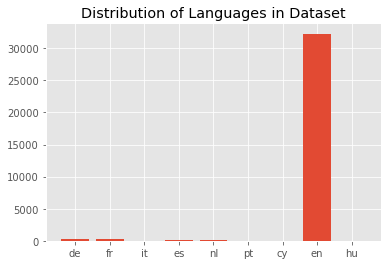

In [10]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [11]:
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32260 entries, 0 to 52338
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             32260 non-null  object
 1   doi                  32260 non-null  object
 2   abstract             32260 non-null  object
 3   body_text            32260 non-null  object
 4   authors              32260 non-null  object
 5   title                32260 non-null  object
 6   journal              32260 non-null  object
 7   abstract_summary     32260 non-null  object
 8   abstract_word_count  32260 non-null  int64 
 9   body_word_count      32260 non-null  int64 
 10  body_unique_words    32260 non-null  int64 
 11  language             32260 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.2+ MB


In [12]:
df.describe()

,abstract_word_count,body_word_count,body_unique_words
count,32260.000000,32260.000000,32260.000000
mean,217.090856,4214.148326,1337.836020
std,154.859318,3247.632211,694.422121
min,1.000000,12.000000,9.000000
25%,144.000000,2513.000000,936.000000
50%,199.000000,3628.000000,1229.000000
75%,256.000000,5199.000000,1612.000000
max,6324.000000,124703.000000,20966.000000


In [13]:
df.to_csv("COVID-19 Literature Clustering Processed Data.csv", index=False)